In [1]:
import numpy as np
import pandas as pd
import json
import re

In [9]:
transcripts_df = pd.read_csv('./data/annotated_transcirpts_117C_v3.csv')

In [3]:
CLEANR = re.compile('<.*?>')
CLEANR2 = re.compile('[.*?]')
CLEANR3 = re.compile("s+")

In [4]:
def clean_text(text):
    temp = re.sub(CLEANR, '', text)
    temp = re.sub(CLEANR2, '', temp)
    temp = temp.replace('\n', ' ')
    temp = re.sub(CLEANR3, ' ', temp).strip()
    temp = temp.lower()
    return temp

In [5]:
transcripts_df['transcript'] = transcripts_df['transcript'].apply(clean_text)

In [6]:
transcripts_df.head()

,Unnamed: 0,meta,transcript,date_x,bill_number,congress,chamber,rollnumber,date_y,session,...,nay_count,nominate_mid_1,nominate_mid_2,nominate_spread_1,nominate_spread_2,nominate_log_likelihood,vote_result,vote_desc,vote_question,dtl_desc
0,148,"{'body': 'H', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 12 (wedne...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
1,156,"{'body': 'S', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 8 (wedne ...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
2,164,"{'body': 'S', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 7 (tue da...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
3,172,"{'body': 'S', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 7 (tue da...",2022-01-23,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN
4,180,"{'body': 'H', 'depth': 2, 'download_timeout': ...","congre ional record, volume 168 i ue 48 (thur ...",2022-03-24,HR1,117,House,51,2021-03-02,1,...,210,0.03,0.037,0.716,-0.099,-0.246,Agreed to,NaN,On Agreeing to the Amendment,NaN


In [71]:
# Load the glove mode
vec_txt_file_lines = open('glove.6B.100d.txt', 'r', encoding="utf8").readlines()

glove = {}

for line in vec_txt_file_lines:
    line_split = line.split(' ')
    key = line_split[0]
    vec = np.array([float(v) for v in line_split[1:]])
    glove[key] = vec

In [8]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

congress_sents = []

for i, row in transcripts_df.iterrows():
    congress_sents.append(row['transcript'].split(' '))

In [9]:
model = Word2Vec(sentences=congress_sents, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [14]:
X_naive_mean = []
X_vec_lst = []
X_w2v_mean = []
Y_naive_mean_yea = []
Y_naive_mean_passed = []

for i, row in transcripts_df.iterrows():
    tx_vecs = []
    w2v_vecs = []
    for w in row['transcript'].split(' '):
        if w in glove:
            tx_vecs.append(glove[w])
            w2v_vecs.append(model.wv[w])

    X_naive_mean.append(np.mean(tx_vecs, axis=0))
    X_vec_lst.append(tx_vecs)
    X_w2v_mean.append(np.mean(w2v_vecs, axis=0))
    Y_naive_mean_yea.append(row['yea_count'])
    Y_naive_mean_passed.append(True if row['vote_result'] == 'Passed' else False)

In [73]:
from sklearn.decomposition import PCA

X_mean_pca = []

for vec in X_vec_lst:
    n_components = min(2, len(vec)) - 1
    tmp = np.mean(PCA(n_components).fit_transform(vec), axis=0)
    X_mean_pca.append(tmp)

/home/timevdo/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.09814981949458483
55.93029381511854


In [16]:
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

0.907716606498195


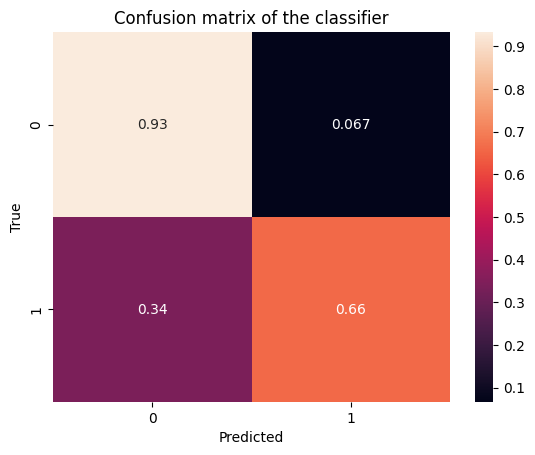

In [27]:
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.3, random_state=42)

model = SGDClassifier(
    class_weight='balanced'
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

0.6938176895306859


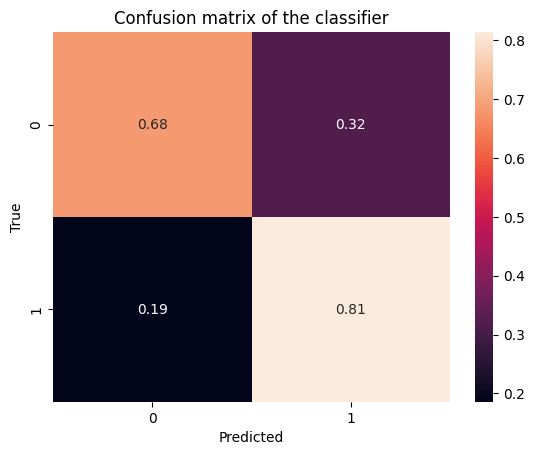

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X_w2v_mean, Y_naive_mean_passed, test_size=0.2, random_state=42)

model = LogisticRegression(
    class_weight='balanced',
    max_iter=400
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/home/timevdo/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/timevdo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8763537906137184


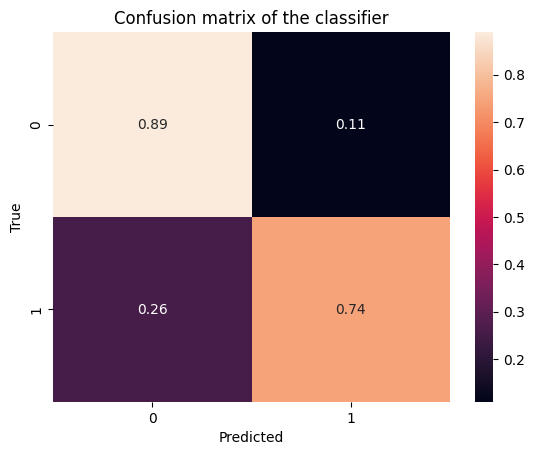

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.3, random_state=42)

model = LinearSVC(
    class_weight='balanced'
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

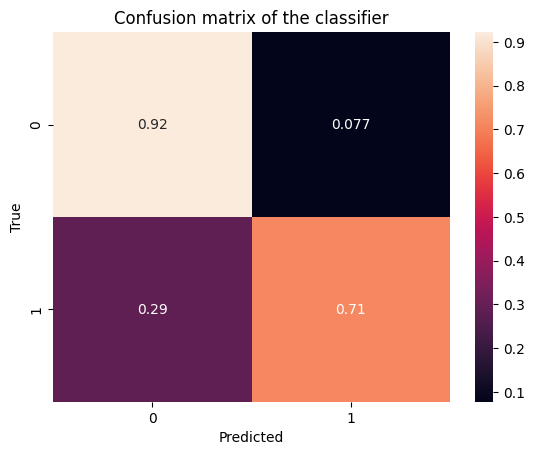

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X_w2v_mean, Y_naive_mean_passed, test_size=0.3, random_state=42)

model = LinearSVC(
    class_weight='balanced',
    ).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
from xgboost import XGBClassifier, XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X_w2v_mean, Y_naive_mean_yea, test_size=0.2, random_state=42)

bst = XGBRegressor(n_estimators=200, learning_rate=0.1)
bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)
print(mean_squared_error(y_test, y_pred)**0.5)

52.22124288506633


0.9465252707581228


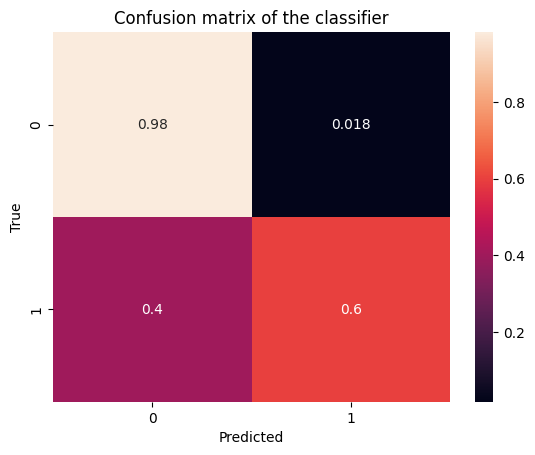

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_passed, test_size=0.2, random_state=42)

bst = XGBClassifier(n_estimators=100, max_depth=150, learning_rate=1, objective='binary:logistic')

bst.fit(X_train, y_train)
y_pred = bst.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# use a simple NN to predict the number of yea votes
# just 5 stacked dense layers

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

# train to predict the number of yea votes given the transcript embedding

model.compile(loss='mean_squared_error', optimizer=Adam())

X_train, X_test, y_train, y_test = train_test_split(
    X_naive_mean, Y_naive_mean_yea, test_size=0.2, random_state=42)

model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size=32, verbose=1)

In [13]:
# lets get the average, std, etc of the number of yea votes from the whole dataset (transcripts_df)

transcripts_df['yea_count'].describe()

count    44319.000000
mean       221.949006
std         56.704273
min         78.000000
25%        208.000000
50%        218.000000
75%        226.000000
max        432.000000
Name: yea_count, dtype: float64